In [1]:
import pandas as pd
import pybaseball as pb
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Ellipse, Polygon

In [2]:
playoff_sc_df = pb.statcast(start_dt='2022-10-07', end_dt='2022-12-01')

This is a large query, it may take a moment to complete


  0%|          | 0/40 [00:00<?, ?it/s]

Skipping offseason dates


100%|██████████| 40/40 [00:10<00:00,  3.91it/s]


we have all the pitches

need to filter down:

* to all the pitches that were put into play
* plot the launch angle and ev
* maybe size by xwOBA
* need to color by out, hit, non-hr extra base hit and homerun

In [3]:
playoff_sc_df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
140,CU,2022-10-20,82.2,-0.14,5.82,"Pressly, Ryan",572761,519151,strikeout,swinging_strike_blocked,...,3,2,3,2,3,Infield shift,Standard,25,0.078,-0.159
144,CH,2022-10-20,89.2,-0.46,5.66,"Pressly, Ryan",572761,519151,None,blocked_ball,...,3,2,3,2,3,Infield shift,Standard,232,0.0,0.023
148,CU,2022-10-20,80.7,-0.24,5.83,"Pressly, Ryan",572761,519151,None,foul,...,3,2,3,2,3,Infield shift,Standard,27,0.0,-0.048
155,SL,2022-10-20,90.0,-0.26,5.94,"Pressly, Ryan",572761,519151,None,called_strike,...,3,2,3,2,3,Infield shift,Standard,127,0.0,-0.035
159,CU,2022-10-20,81.2,-0.19,5.82,"Pressly, Ryan",518626,519151,walk,ball,...,3,2,3,2,3,Standard,Standard,23,-0.043,0.101


In [4]:
playoff_sc_df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [6]:
def simplified_events(event):
    return {
        "home_run" : "Home Run",
        "single" : "Single",
        "double" : "Double",
        "triple" : "Triple"
    }.get(event, "Out(s)")

In [7]:
plot_df = (
    playoff_sc_df
        .pipe(lambda df: df[df.description == "hit_into_play"])
        .pipe(lambda df: df.dropna(subset=["launch_angle"]))
        .pipe(lambda df: df.assign(launch_rad= df.launch_angle.apply(math.radians)))
        .pipe(lambda df: df.assign(simple_event= df.events.apply(simplified_events)))
)

In [8]:
plot_df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,launch_rad,simple_event
178,FF,2022-10-20,90.6,1.67,5.76,"Peralta, Wandy",663656,593974,field_out,hit_into_play,...,3,3,2,Infield shift,Standard,128,-0.014,-0.307,1.396263,Out(s)
212,SI,2022-10-20,94.9,0.02,6.29,"Peralta, Wandy",608324,593974,single,hit_into_play,...,3,3,2,Strategic,Standard,137,0.007,0.133,0.104720,Single
237,SI,2022-10-20,96.1,1.75,6.09,"Peralta, Wandy",670541,593974,single,hit_into_play,...,3,3,2,Infield shift,Standard,135,0.014,0.306,0.244346,Single
137,CH,2022-10-20,89.3,-1.98,5.68,"Loáisiga, Jonathan",665161,642528,field_out,hit_into_play,...,3,3,2,Standard,Standard,242,-0.013,-0.254,-0.785398,Out(s)
186,SL,2022-10-20,88.9,-2.17,5.66,"Abreu, Bryan",592450,650556,field_out,hit_into_play,...,3,2,3,Standard,Strategic,64,0.043,-0.3,0.488692,Out(s)


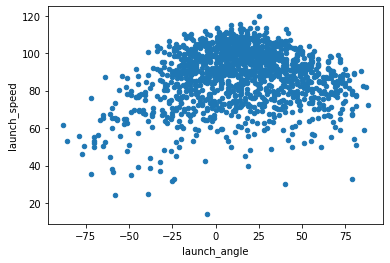

In [9]:
# let's sketch it out real quick
plot_df.plot(kind="scatter", x="launch_angle", y="launch_speed")

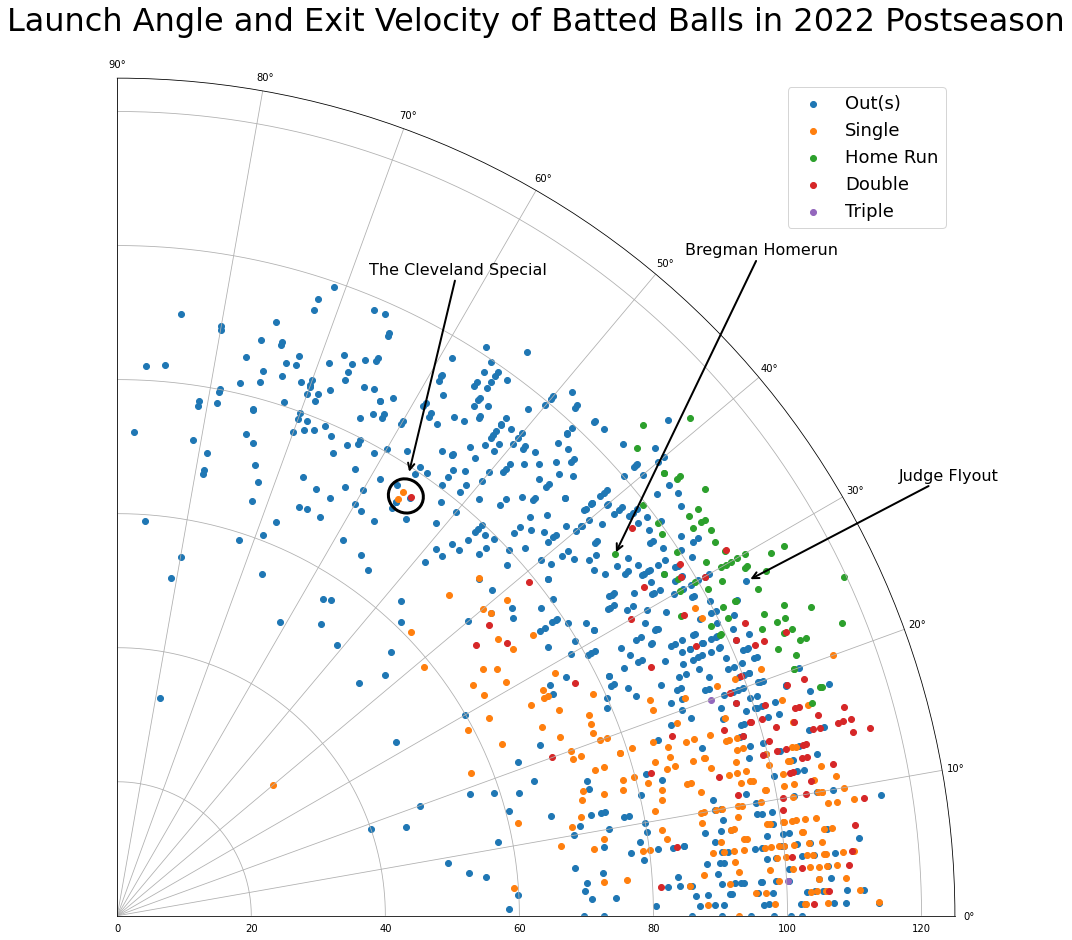

In [10]:
f, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(15,15))

for event in plot_df.simple_event.unique():
    sub_plot_df = plot_df.query(f"simple_event == '{event}'")
    ax.scatter(sub_plot_df.launch_rad, sub_plot_df.launch_speed, label=event)

    
ax.annotate(
    "Judge Flyout",
    (math.radians(28),106.68),
    size=16,
    xytext = (150, 100),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->", lw=2)
)

ax.annotate(
    "Bregman Homerun",
    (math.radians(36), 91.8),
    size=16,
    xytext = (70, 300),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->", lw=2)
)

ax.annotate(
    "The Cleveland Special",
    (math.radians(56.6), 79),
    size=16,
    xytext = (-40, 200),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->", lw=2)
)

ax.add_patch(Ellipse(xy=(math.radians(55.5), 76), 
                     width=.07, 
                     height=5, fill=False, ls="-", lw=3, color="k"))

    
ax.set_thetamin(0)
ax.set_thetamax(90)

plt.title("Launch Angle and Exit Velocity of Batted Balls in 2022 Postseason", size=32)
plt.legend(loc="upper right", fontsize=18)

plt.tight_layout()
plt.savefig("postseason_batted_balls.png")